# Mengidentifikasi Umur berdasarkan gambar

## Inisialisasi 

In [1]:
# memuat modul
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

## Memuat Data

Dataset yang kamu perlukan disimpan di folder `/datasets/faces/`. Pada folder tersebut, kamu bisa menemukan: - Folder `final_file` dengan 7,6 ribu foto 
- File `labels.csv` yang memuat label, dengan dua kolom: `file_name` dan `real_age` 
Mengingat jumlah file gambar cukup banyak, kamu disarankan untuk tidak membacanya sekaligus, karena hal ini hanya akan menghabiskan sumber daya komputasi. Untuk itu, kami sarankan kamu untuk membuat generator dengan ImageDataGenerator. Metode ini telah dijelaskan sebelumnya di Bab 3, Pelajaran ke-7. 
File label bisa dimuat sebagai file CSV biasa.

In [2]:
# memuat path untuk data train dan dataset target (label)
face_path = '/datasets/faces/final_files/'
label_path = '/datasets/faces/labels.csv'

In [3]:
# memuat dataset label
labels = pd.read_csv(label_path)

# memuat data train menggunakan ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=face_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
# mengecek informasi dataset label
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


data terdiri dari 2 kolom dengan jumlah entri `7591`

In [5]:
# menampilkan sampel dataset label
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
# mengecek duplikasi data
labels.duplicated().sum()

0

tidak ada duplikasi data

In [8]:
# melakukan separasi fitur dan label
feature, label = next(train_gen_flow)

In [9]:
# shape dari fitur
feature.shape

(32, 224, 224, 3)

In [10]:
# shape dari label
label.shape

(32,)

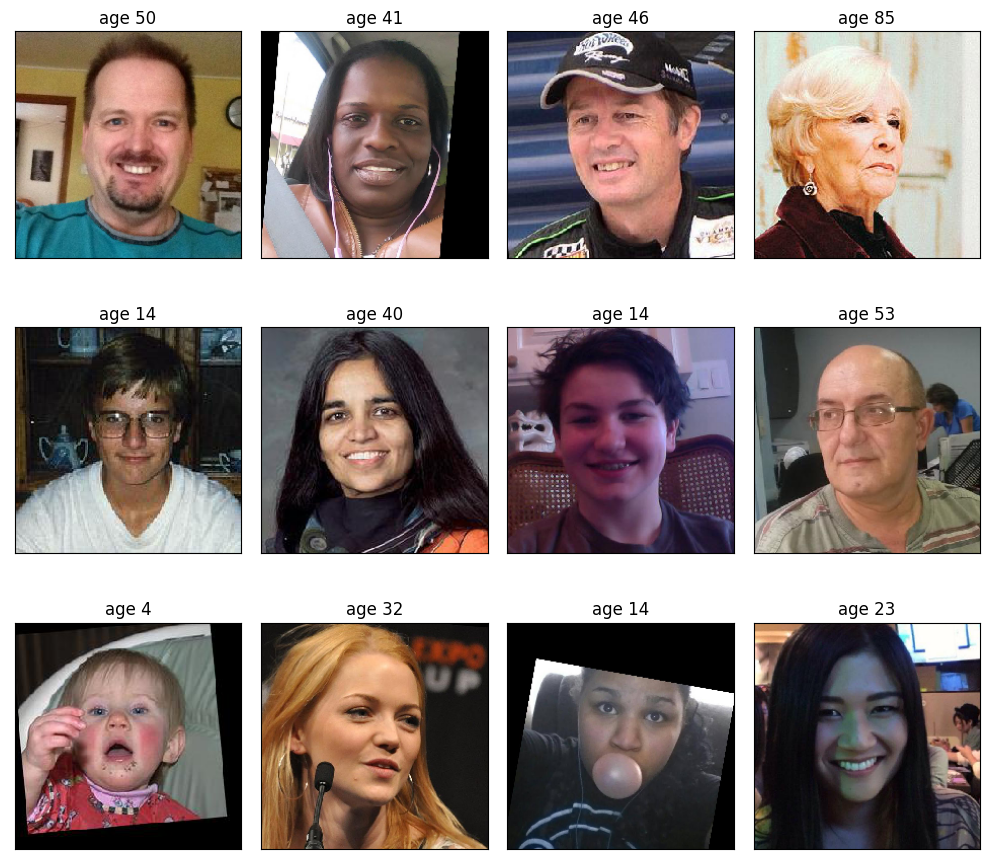

In [13]:
# Melihat tampilan wajah yang ada pada file
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3,4, i+1)
    plt.imshow(feature[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'age {label[i]}')
    plt.tight_layout()

**Kesimpulan:** data terdiri dari 2 kolom dengan jumlah entri `7591`, tidak da nilai hilang dan duplikasi data. terlihat bahwa umur dan gambar cukup mendiskripsikan yang kita butuhkan.

## EDA

Selanjutnya, kita akan melakukan Analisis Data Eksploratif (EDA) untuk melihat distribusi usia pada dataset dan juga mencocokan antara image/foto dengan label usia.

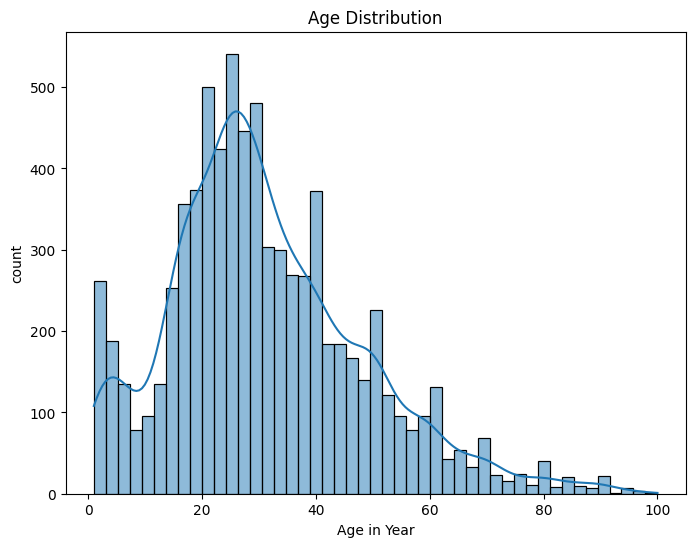

In [14]:
# visualisasi distribusi usia
plt.figure(figsize=(8,6))
sns.histplot(data=labels, x="real_age", kde=True)
plt.title('Age Distribution')
plt.xlabel('Age in Year')
plt.ylabel('count')
plt.show()

terlihat bahwa distribusi umur yang dihasilkan meningkat pada sekitar umur `20-40` tahun.

### Temuan

In [16]:
# Melihat perbandingan data asli dengan data yang digunakan
highlight = labels[labels['real_age'].isin(label)].reset_index(drop=True)

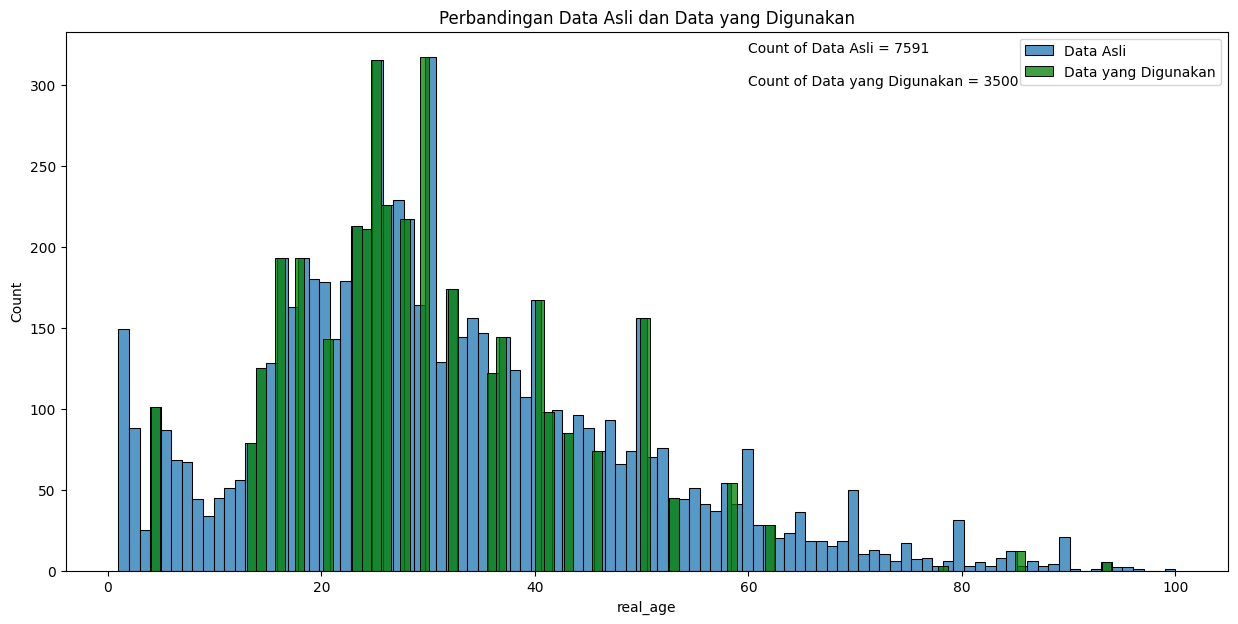

In [17]:
plt.figure(figsize=(15, 7))
sns.histplot(labels['real_age'],bins=100,label='Data Asli')
sns.histplot(highlight['real_age'],bins=100,color='green',label='Data yang Digunakan')
plt.title('Perbandingan Data Asli dan Data yang Digunakan')
plt.text(60,320,f'Count of Data Asli = {labels.count()[0]}')
plt.text(60,300,f'Count of Data yang Digunakan = {highlight.count()[0]}')
plt.legend()
plt.show()

sama seperti sebelumnya terlihat bahwa orang dengan umur sekitar `20-40` adalah yang paling banyak masuk di dataset kita.

## Pemodelan 

Definisikan fungsi-fungsi yang diperlukan untuk melatih modelmu pada platform GPU dan buat satu skrip yang berisi semua fungsi tersebut beserta bagian inisialisasi.
Untuk mempermudah tugas ini, kamu bisa mendefinisikannya dalam notebook ini dan menjalankan kode siap pakai di bagian berikutnya untuk menyusun skrip secara otomatis.
Oh ya, definisi di bawah ini juga akan diperiksa oleh project reviewer agar mereka bisa memahami caramu membangun model.

In [18]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [19]:
# membuat fungsi untuk memuat dataset `train`
def load_train(path):
    
    """
    Kode ini memuat bagian training set dari file path
    """
    
    # memuat path untuk data train dan label train
    face_path = path + 'final_files/'
    label_path = path + 'labels.csv'

    # memuat dataset label train
    labels = pd.read_csv(label_path)

    # memuat data train menggunakan ImageDataGenerator    
    train_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=face_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
    
    return train_gen_flow

In [20]:
# membuat fungsi untuk memuat dataset `test`
def load_test(path):
    
    """
    Kode ini memuat bagian validation set/test set dari file path
    """
    
    # memuat path untuk data test dan label test
    face_path = path + 'final_files/'
    label_path = path + 'labels.csv'

    # memuat dataset label test
    labels = pd.read_csv(label_path)

    # memuat data test menggunakan ImageDataGenerator   
    test_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=face_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

    return test_gen_flow

Disini kita akan mendefinisikan model CNN, optimizer, dan metrik. Model yang kita gunakan adalah ResNet50 dimana kita akan melatihnya kembali trainable=True dengan menggunakan parameter imagenet. Optimizer yang akan kita gunakan adalah Adam, metrik loss adalah MSE, dan metrik scoring adalah MAE.

In [21]:
# membuat fungsi untuk mendefinisikan model CNN
def create_model(input_shape=(224,224,3)):
    
    """
    Kode ini mendefinisikan model
    """
    
    # rangkaian CNN
    resnet = ResNet50(input_shape=input_shape,
                 include_top=False,classes=1000,
                 weights='imagenet') 
    resnet.trainable = True
    model = Sequential()
    model.add(resnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    # optimizer dan metrik
    model.compile(
        optimizer=Adam(),
        loss='mean_squared_error',
        metrics=['mae'],
    )

    return model

Terakhir, kita akan membuat fungsi untuk menjalankan training dan test secara bersamaan dimana jumlah epoch yang kita gunakan sebanyak 20 epoch.

In [22]:
# membuat fungsi untuk melatih dan menguji model CNN
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Melatih model dengan parameter yang diberikan
    """
    
    # training dan validasi model CNN
    model.fit(train_data,
            validation_data=test_data,
            batch_size=batch_size,
            epochs=epochs,
            steps_per_epoch= len(train_data) if steps_per_epoch is None else steps_per_epoch,
            validation_steps= len(test_data) if validation_steps is None else validation_steps,
            verbose=2)

    return model

## Siapkan Skrip untuk menjalankan platform GPU

Setelah kamu mendefinisikan fungsi-fungsi yang diperlukan, kamu bisa membuat skrip untuk platform GPU, mengunduhnya melalui menu "File|Open...", dan mengunggahnya nanti untuk dijalankan pada platform GPU. "

Catatan: Skrip kamu juga harus menyertakan bagian inisialisasi. Contohnya ditunjukkan di bawah ini.

In [23]:
# mempersiapkan skrip untuk dijalankan pada platform GPU

init_str = """
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
"""

import inspect
with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Letakkan output dari platform GPU sebagai sel Markdown di sini. ini adalah hasil yang kita dapatkan sebelumnya:

```python
Train for 356 steps, validate for 119 steps
Epoch 1/20
2024-06-13 16:20:03.455959: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-06-13 16:20:03.738694: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-06-13 16:20:05.539430: I tensorflow/stream_executor/cuda/cuda_driver.cc:801] failed to allocate 2.65G (2844409856 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
356/356 - 54s - loss: 224.6476 - mae: 11.0977 - val_loss: 617.8838 - val_mae: 19.8684
Epoch 2/20
356/356 - 45s - loss: 112.2332 - mae: 8.0516 - val_loss: 190.0632 - val_mae: 10.5167
Epoch 3/20
356/356 - 46s - loss: 89.4296 - mae: 7.2474 - val_loss: 170.7977 - val_mae: 9.7647
Epoch 4/20
356/356 - 46s - loss: 73.0508 - mae: 6.5420 - val_loss: 131.3046 - val_mae: 8.8356
Epoch 5/20
356/356 - 46s - loss: 64.2900 - mae: 6.1631 - val_loss: 112.6558 - val_mae: 7.8958
Epoch 6/20
356/356 - 44s - loss: 52.4940 - mae: 5.5337 - val_loss: 92.9806 - val_mae: 7.2831
Epoch 7/20
356/356 - 46s - loss: 45.3082 - mae: 5.1642 - val_loss: 90.4042 - val_mae: 7.1320
Epoch 8/20
356/356 - 46s - loss: 41.2585 - mae: 4.8569 - val_loss: 117.2439 - val_mae: 8.0120
Epoch 9/20
356/356 - 46s - loss: 33.4929 - mae: 4.4530 - val_loss: 88.6180 - val_mae: 7.0506
Epoch 10/20
356/356 - 46s - loss: 27.2618 - mae: 4.0016 - val_loss: 81.3005 - val_mae: 6.7938
Epoch 11/20
356/356 - 44s - loss: 27.3152 - mae: 3.9596 - val_loss: 86.2158 - val_mae: 6.9885
Epoch 12/20
356/356 - 46s - loss: 24.4061 - mae: 3.7797 - val_loss: 77.9761 - val_mae: 6.6302
Epoch 13/20
356/356 - 46s - loss: 23.8647 - mae: 3.7194 - val_loss: 129.1567 - val_mae: 9.0497
Epoch 14/20
356/356 - 46s - loss: 23.1572 - mae: 3.6259 - val_loss: 80.7155 - val_mae: 6.6599
Epoch 15/20
356/356 - 45s - loss: 18.8616 - mae: 3.3069 - val_loss: 74.8481 - val_mae: 6.4900
Epoch 16/20
356/356 - 45s - loss: 18.9611 - mae: 3.3169 - val_loss: 114.6859 - val_mae: 7.9772
Epoch 17/20
356/356 - 46s - loss: 18.8483 - mae: 3.2789 - val_loss: 77.6151 - val_mae: 6.6243
Epoch 18/20
356/356 - 46s - loss: 16.3509 - mae: 3.0774 - val_loss: 74.6041 - val_mae: 6.4049
Epoch 19/20
356/356 - 46s - loss: 14.5422 - mae: 2.9131 - val_loss: 79.6750 - val_mae: 6.7495
Epoch 20/20
356/356 - 43s - loss: 14.7898 - mae: 2.9395 - val_loss: 80.1149 - val_mae: 6.7984
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 80.1149 - mae: 6.7984
Test MAE: 6.7984
```

## Kesimpulan

setelah melakukan training dan test pada dataset menggunakan ResNet50 dengan Epoch `20` dihasilkan loss `80.11` dan mae `6.79` yang berarti model ini sudah cukup baik akan tetapi masih butuh perbaikan untuk menurunkan nilai mae agar bisa lebih baik lagi.

### Temuan

1. data terdiri dari 2 kolom dengan jumlah entri `7591`, tidak da nilai hilang dan duplikasi data. terlihat bahwa umur dan gambar cukup mendiskripsikan yang kita butuhkan.
2. terlihat bahwa distribusi umur yang pada dataset meningkat pada sekitar umur `20-40` tahun, yang berarti dataset kita memiliki input usia paling banyak pada rentang tersebut

### Rekomendasi

untuk melakukan optimalisasi pada model ini disarankan untuk menangani `Error CUDA Out of Memory`. Pada awal pelatihan, terdapat `error CUDA_ERROR_OUT_OF_MEMORY`. Ini menunjukkan bahwa GPU kehabisan memori saat mencoba mengalokasikan ruang untuk operasi. Berikut adalah beberapa cara untuk menangani masalah ini:
1. Kurangi Batch Size: Mengurangi ukuran batch dapat membantu mengurangi penggunaan memori GPU. Misalnya, jika batch size Anda saat ini adalah 32, cobalah menguranginya menjadi 16 atau 8.
2. Gunakan Model yang Lebih Ringan: Jika memungkinkan, gunakan model yang lebih ringan atau kurangi jumlah layer dan parameter pada model Anda.
3. Gradient Checkpointing: Teknik ini memungkinkan Anda untuk mengurangi penggunaan memori dengan mengorbankan sedikit waktu komputasi. Ini dapat membantu saat melatih model yang sangat besar.
4. Upgrade GPU: Jika memungkinkan, gunakan GPU dengan kapasitas memori yang lebih besar.
5. Optimasi Memori: Bersihkan memori GPU yang tidak terpakai menggunakan kode berikut sebelum memulai pelatihan 
`import torch
torch.cuda.empty_cache()`